# K-Means – Wine Quality (Vin rouge)

Ce notebook applique **K-Means** selon le cahier des charges :
- Segmenter les vins en 3-5 groupes
- Comparer avec les catégories de qualité
- Évaluer avec silhouette score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project (File > Open Folder) puis relancez.")
from preprocessing import load_data, clean_data, scale_features
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mlflow
import mlflow.sklearn

mlflow.set_experiment("wine-quality-kmeans")

2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 18:17:44 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 18:17:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/14 18:17:45 INFO mlflow.store.db.utils: Updating database tables
2026/02/14 18:17:46 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 18:17:46 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/14 18:17:46 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/14 18:1

<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/clustering/KMeans/mlruns/1', creation_time=1771089472089, experiment_id='1', last_update_time=1771089472089, lifecycle_stage='active', name='wine-quality-kmeans', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y = df["quality"]

X_scaled, scaler = scale_features(X)

# PCA 2D pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Dataset shape: {df.shape}")

Dataset shape: (1359, 12)


## 3. Test de différents k (3-5 groupes selon cahier des charges)

In [3]:
# Test de k = 3, 4, 5
k_values = [3, 4, 5]
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    print(f"k={k}: Silhouette score = {sil:.3f}")

C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\subprocess.py", line 971, in __init__
    sel

k=3: Silhouette score = 0.188
k=4: Silhouette score = 0.169
k=5: Silhouette score = 0.188


## 4. Visualisation des clusters pour k=4

Silhouette score (K-Means, k=4): 0.169


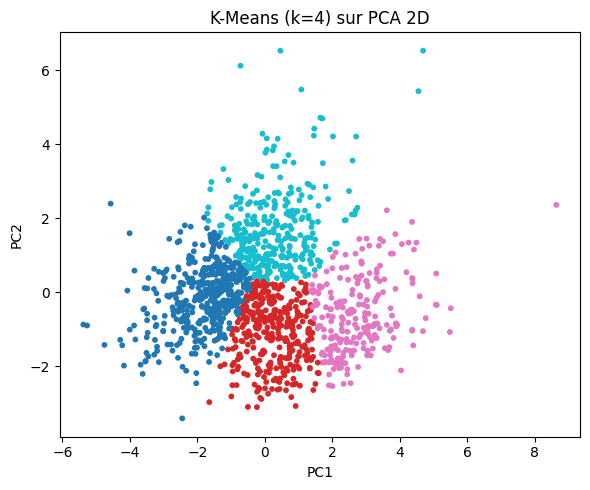

In [4]:
# K-Means avec k=4 (exemple)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
labels_pca = kmeans.fit_predict(X_pca)

sil = silhouette_score(X_scaled, labels)
print(f"Silhouette score (K-Means, k={k}): {sil:.3f}")

# Visualisation sur PCA 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap="tab10", s=10)
plt.title(f"K-Means (k={k}) sur PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("kmeans_clusters.png")
plt.show()

## 5. Comparaison avec les catégories de qualité

Répartition qualité par cluster:
             mean       std  count
cluster                           
0        5.325088  0.577632    283
1        5.911765  0.836753    340
2        5.289760  0.724587    459
3        6.126354  0.795316    277


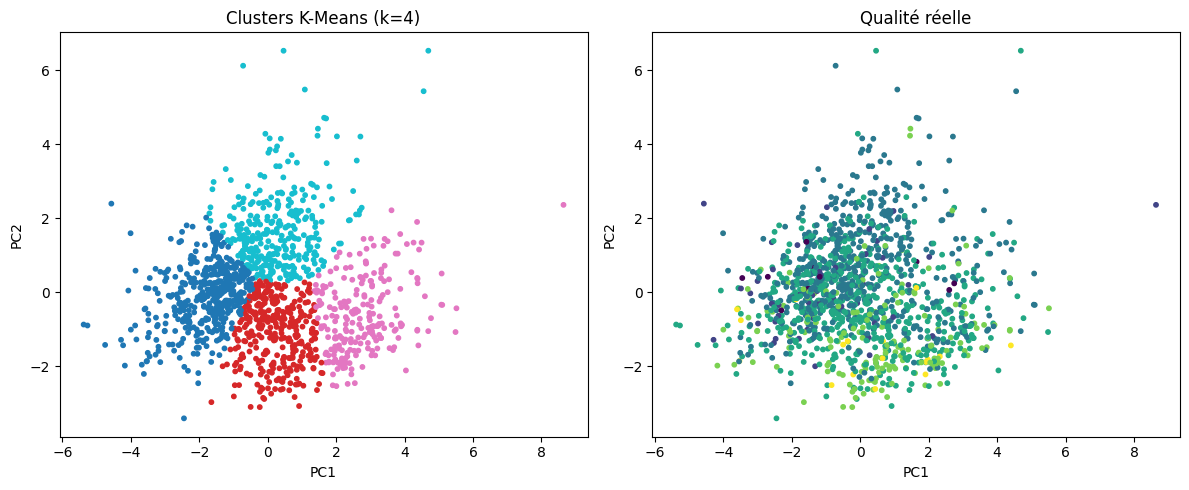

In [5]:
# Comparaison clusters vs qualité réelle
comparison_df = pd.DataFrame({
    'cluster': labels,
    'quality': y
})

print("Répartition qualité par cluster:")
print(comparison_df.groupby('cluster')['quality'].agg(['mean', 'std', 'count']))

# Visualisation clusters vs quality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap="tab10", s=10)
axes[0].set_title(f"Clusters K-Means (k={k})")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=10)
axes[1].set_title("Qualité réelle")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.savefig("kmeans_comparison.png")
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name=f"KMeans_k{k}"):
    mlflow.log_param("n_clusters", k)
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("silhouette_score", float(sil))
    mlflow.log_artifact("kmeans_clusters.png")
    mlflow.log_artifact("kmeans_comparison.png")
    mlflow.sklearn.log_model(kmeans, "kmeans_model")
    print("MLflow run terminé")

2026/02/14 18:18:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
